**Time series analysis**<br>
**Lund University**<br>
<br>
**Example code 24:** Form a k-step prediction of an ARMA process with unknown parameters using the Kalman filter (see also example 8.12).<br>
<br>
**Note:** This is an IMPORTANT example!<br>
<br>
**Reference:** "An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson, Studentlitteratur, 2021

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))


from tsa_lth.analysis import plotACFnPACF, plotWithConf, naive_pred
from tsa_lth.tests import whiteness_test

## Simulate a process.

In [9]:
# Set the seed (just done for the lecture!)
np.random.seed(1)
extraN = 100
N = 1000
A0 = np.convolve([1] + [0]*5 + [-1], [1, -0.7])  # Try changing the polynomials - but note that you need to change the C vector then!
C0 = np.array([1, 0.5, 0, -0.2])
e = np.random.randn(N + extraN)
y = signal.lfilter(C0, A0, e)
y = y[extraN:]
e = e[extraN:]

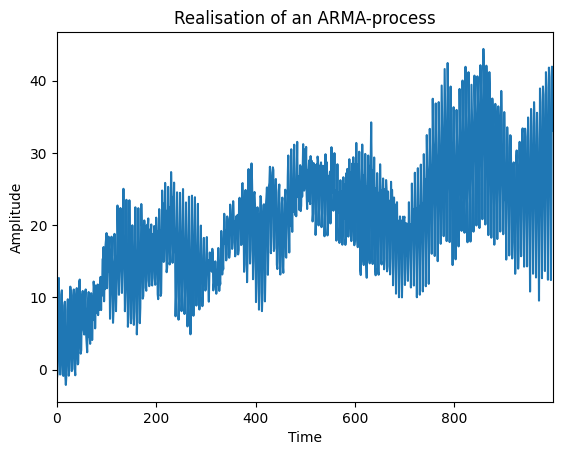

In [10]:
# Plot realisation.
plt.figure()
plt.plot(y)
plt.title('Realisation of an ARMA-process')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.xlim([0, N-1])
plt.show()

## Estimate the unknown parameters using a Kalman filter and form the k-step prediction.

In [11]:
# k-step prediction. This code assumes that k<7 (otherwise, change line 80).
k = 3
p0 = 3  # Number of unknowns in the A polynomial (note: this is only the non-zero parameters!).
q0 = 2  # Number of unknowns in the C polynomial (note: this is only the non-zero parameters!).

A = np.eye(p0 + q0)
Rw = 1  # Measurement noise covariance matrix, R_w. Note that Rw has the same dimension as Ry.
Re = 1e-6 * np.eye(p0 + q0)  # System noise covariance matrix, R_e. Note that Re has the same dimension as Rx_t1.
Rx_t1 = np.eye(p0 + q0)  # Initial covariance matrix, R_{1|0}^{x,x}
Rx_k = Rx_t1.copy()
h_et = np.zeros(N)  # Estimated one-step prediction error.
xt = np.zeros((p0 + q0, N - k))  # Estimated states. Intial state, x_{1|0} = 0.
yhat = np.zeros(N - k)  # Estimated output.
yhatk = np.zeros(N)  # Estimated k-step prediction.
xStd = np.zeros((p0 + q0, N - k))  # Stores one std for the one-step prediction.
xStdk = np.zeros((p0 + q0, N - k))  # Stores one std for the k-step prediction.

In [12]:
# We use t-7, so start at t=8. As we form a k-step prediction, end the loop at N-k.
for t in range(7, N - k):  # t=8 in MATLAB (1-indexed) is t=7 in Python (0-indexed)
    # Update the predicted state and the time-varying state vector.
    x_t1 = A @ xt[:, t - 1]  # x_{t|t-1} = A x_{t-1|t-1}
    C = np.array([[-y[t - 1], -y[t - 6], -y[t - 7], h_et[t - 1], h_et[t - 3]]])  # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw  # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry  # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]  # One-step prediction, \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat[t]  # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}
    xt[:, t] = x_t1 + (Kt * h_et[t]).flatten()  # x_{t|t}= x_{t|t-1} + K_t ( y_t - Cx_{t|t-1} )
    
    # Update the covariance matrix estimates.
    Rx_t = Rx_t1 - Kt @ Ry @ Kt.T  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re  # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re
    
    # Form the k-step prediction by first constructing the future C vector
    # and the one-step prediction. Note that this is not yhat(t) above, as
    # this is \hat{y}_{t|t-1}.
    Ck = np.array([[-y[t], -y[t - 5], -y[t - 6], h_et[t], h_et[t - 2]]])  # C_{t+1|t}
    yk = (Ck @ xt[:, t])[0]  # \hat{y}_{t+1|t} = C_{t+1|t} A x_{t|t}
    
    # Note that the k-step predictions is formed using the k-1, k-2, ...
    # predictions, with the predicted future noises being set to zero. If
    # the ARMA has a higher order AR part, one needs to keep track of each
    # of the earlier predicted values.
    Rx_k = Rx_t1.copy()
    for k0 in range(2, k + 1):
        Ck = np.array([[-yk, -y[t - 6 + k0], -y[t - 7 + k0], h_et[t + k0 - 1], h_et[t + k0 - 3]]])  # C_{t+k|t}
        Ak = np.linalg.matrix_power(A, k0)
        yk = (Ck @ Ak @ xt[:, t])[0]  # \hat{y}_{t+k|t} = C_{t+k|t} A^k x_{t|t}
        Rx_k = A @ Rx_k @ A.T + Re  # R_{t+k+1|t}^{x,x} = A R_{t+k|t}^{x,x} A^T + Re
    
    yhatk[t + k] = yk  # Note that this should be stored at t+k.
    
    # Estimate a one std confidence interval of the estimated parameters.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))  # This is one std for each of the parameters for the one-step prediction.
    xStdk[:, t] = np.sqrt(np.diag(Rx_k))  # This is one std for each of the parameters for the k-step prediction.

## Examine the estimated parameters.

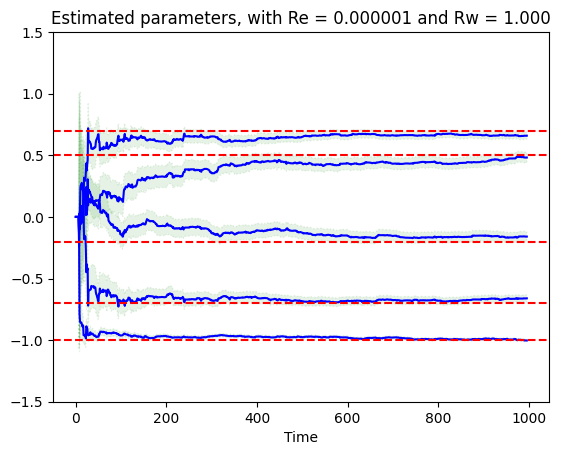

The final values of the estimated parameters are:
  True value: -0.70, estimated value: -0.66 (+/- 0.0289).
  True value: -1.00, estimated value: -1.00 (+/- 0.0102).
  True value:  0.70, estimated value:  0.66 (+/- 0.0296).
  True value:  0.50, estimated value:  0.48 (+/- 0.0434).
  True value: -0.20, estimated value: -0.16 (+/- 0.0410).


In [13]:
# If you examine the confidence interval for the k-step prediction, you
# will find that this is very close to the one-step prediction for these
# settings (use xStdk). Why is that?
trueParams = np.array([A0[1], A0[6], A0[7], C0[1], C0[3]])  # These are the true parameters we seek.
plt.figure()
plotWithConf(np.arange(N - k), xt.T, xStd.T, trueParams)
plt.title(f'Estimated parameters, with Re = {Re[0, 0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.ylim([-1.5, 1.5])
plt.show()

print('The final values of the estimated parameters are:')
for k0 in range(len(trueParams)):
    print(f'  True value: {trueParams[k0]:5.2f}, estimated value: {xt[k0, -1]:5.2f} (+/- {xStd[k0, -1]:5.4f}).')

## Show the one-step prediction.

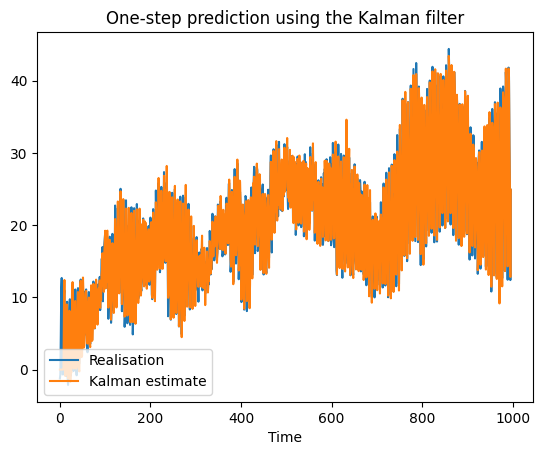

In [14]:
plt.figure()
plt.plot(y[:N - k], label='Realisation')
plt.plot(yhat, label='Kalman estimate')
plt.title('One-step prediction using the Kalman filter')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

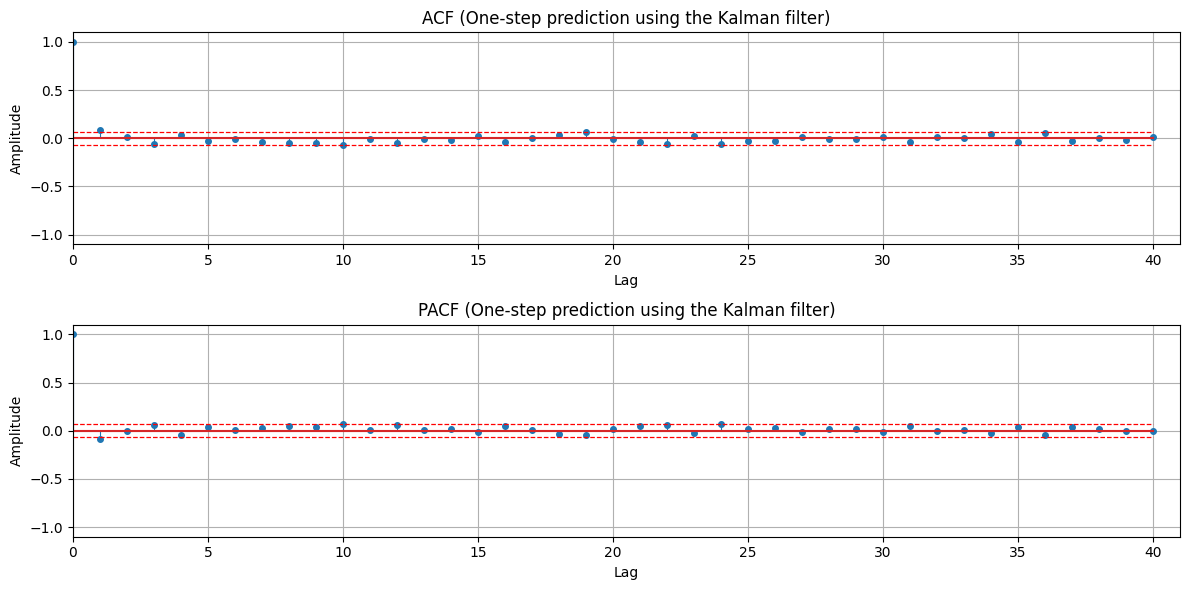

Examining the one-step residual.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 35.42 < 37.65)
  McLeod-Li test:        True (white if 27.94 < 37.65)
  Monti test:            True (white if 35.94 < 37.65)
  Sign change test:      True (white if 0.49 in [0.47,0.53])


In [8]:
# Ignore the initial values to let the filter converge first.
e1 = y[199:N - k] - yhat[199:]
plotACFnPACF(e1, 40, 'One-step prediction using the Kalman filter')
print('Examining the one-step residual.')
whiteness_test(e1)

## Show the k-step prediction.

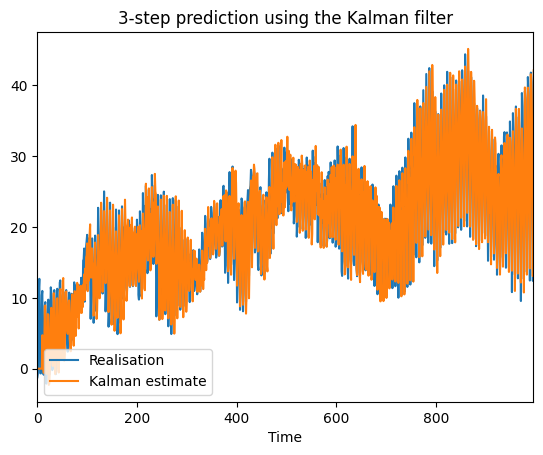

In [9]:
plt.figure()
plt.plot(y, label='Realisation')
plt.plot(yhatk, label='Kalman estimate')
plt.title(f'{k}-step prediction using the Kalman filter')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.xlim([0, N - k - 1])
plt.show()

## Consider the last 200 samples as the validation data.

In [10]:
# Does it make more sense to add a season of 6 here?
testDataInd = np.arange(N - 200, N)
yNaive, var_naive, _ = naive_pred(y, testDataInd, k)

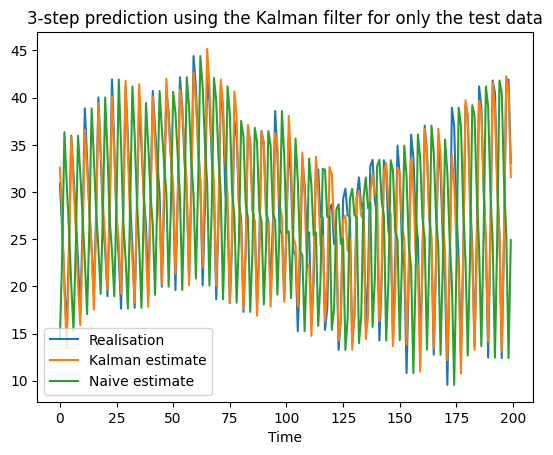

In [11]:
plt.figure()
plt.plot(y[testDataInd], label='Realisation')
plt.plot(np.arange(len(testDataInd)), yhatk[testDataInd], label='Kalman estimate')
plt.plot(yNaive, label='Naive estimate')
plt.title(f'{k}-step prediction using the Kalman filter for only the test data')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

## Examine k-step prediction residual.

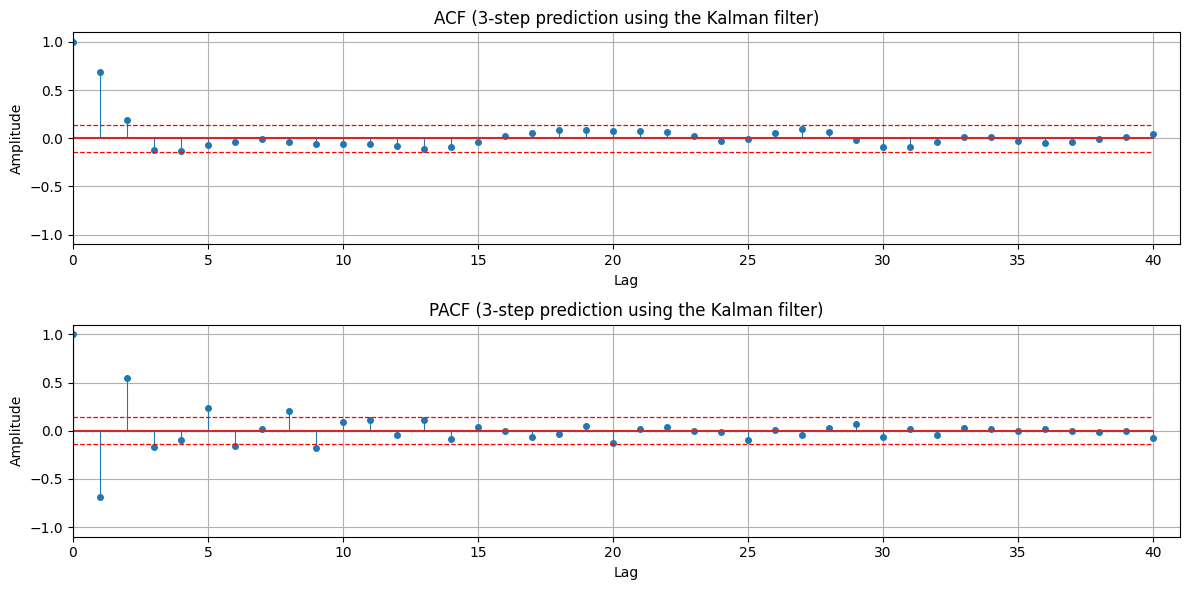

In [12]:
# Here, as an example, we condider the last 200 samples as our validation
# data, and therefore extract just this part to compute the prediction residual.
ek = y[testDataInd] - yhatk[testDataInd]  # Ignore the initial values to let the filter converge first.
plotACFnPACF(ek, 40, f'{k}-step prediction using the Kalman filter')

In [13]:
print(f'  The variance of original signal is                {np.var(y, ddof=1):5.2f}.')
print(f'  The variance of the 1-step prediction residual is  {np.var(e1, ddof=1):5.2f}.')
print(f'  The variance of the {k}-step prediction residual is  {np.var(ek, ddof=1):5.2f}.')
print(f'  The variance of the {k}-step naive predictor is     {var_naive:5.2f}.')

  The variance of original signal is                72.99.
  The variance of the 1-step prediction residual is   1.06.
  The variance of the 3-step prediction residual is   3.36.
  The variance of the 3-step naive predictor is     184.15.
